In [1]:
### ------------------------------- ###
### Revenue Budget & Financial Plan ###
### Author: Asim Jamal              ###
### Dataset link : https://data.cityofnewyork.us/City-Government/Revenue-Budget-Financial-Plan-Exec-Adpt-Prel/ugzk-a6x4/about_data ###
### ------------------------------- ###

In [40]:
#Installing Packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from time import sleep

In [18]:
# NYC Open Data API endpoint (dataset ID: ugzk-a6x4) using SODA2 version
API_URL = "https://data.cityofnewyork.us/resource/ugzk-a6x4.json"

In [19]:
# Fetch data
params = {
    "$limit": 50000,
    "$order": "fiscal_year DESC"
}
print("📡 Fetching data from NYC Open Data API...")
response = requests.get(API_URL, params=params)
print("Status Code:", response.status_code)

📡 Fetching data from NYC Open Data API...
Status Code: 200


In [20]:
# Check for errors
data = response.json()
print(f"✅ Retrieved {len(data)} rows.")

✅ Retrieved 1000 rows.


In [25]:
limit = 50000
offset = 0
all_data = []

print("📡 Fetching data from NYC Open Data API in chunks...")

while True:
    params = {
        "$limit": limit,
        "$offset": offset,
        "$order": "fiscal_year DESC"
    }

    response = requests.get(API_URL, params=params)
    if response.status_code != 200:
        print(f"❌ Error {response.status_code}: {response.text}")
        break

    data_chunk = response.json()
    if not data_chunk:  # no more data
        break

    all_data.extend(data_chunk)
    print(f"✅ Retrieved {len(data_chunk)} rows (total so far: {len(all_data)})")

    offset += limit
    sleep(0.5)  # be polite to the API, avoid rate limits

print(f"\nTotal rows fetched: {len(all_data)}")

📡 Fetching data from NYC Open Data API in chunks...
✅ Retrieved 50000 rows (total so far: 50000)
✅ Retrieved 1709 rows (total so far: 51709)

Total rows fetched: 51709


In [26]:
# Convert to DataFrame
df = pd.DataFrame(all_data)
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
print(df.head())

# Save cleaned copy
df.to_csv("/Users/asimjamal/Documents/Git/FP&A/Data/nyc_revenue_full.csv", index=False)
print("\n💾 Saved full dataset to as nyc_revenue_full.csv")

Columns: ['publication_date', 'fundind_source_name', 'fps_group', 'fps_group_name', 'agency_number', 'agency_name', 'revenue_category', 'revenue_category_name', 'revenue_class_code', 'revenue_class_name', 'budget_code', 'revenue_source', 'revenue_source_name', 'revenue_structure_description', 'adopted_budget_amount', 'current_modified_budget_amount', 'yr1_fy', 'year_1_revenue_amount', 'year_2_revenue_amount', 'year_3_revenue_amount', 'year_4_revenue_amount', 'year_5_revenue_amount', 'fiscal_year']
Shape: (51709, 23)
  publication_date fundind_source_name fps_group        fps_group_name  \
0        2017 4 26      Federal Grants        35       Other - Federal   
1        2017 4 26        State Grants        40  Other - State Grants   
2        2017 4 26      Federal Grants        35       Other - Federal   
3        2017 4 26          City Funds        23         Miscellaneous   
4        2017 4 26        State Grants        37     Education - State   

  agency_number                  

### Basic structure and quality check

In [36]:
print(df.columns.tolist())

['publication_date', 'fundind_source_name', 'fps_group', 'fps_group_name', 'agency_number', 'agency_name', 'revenue_category', 'revenue_category_name', 'revenue_class_code', 'revenue_class_name', 'budget_code', 'revenue_source', 'revenue_source_name', 'revenue_structure_description', 'adopted_budget_amount', 'current_modified_budget_amount', 'yr1_fy', 'year_1_revenue_amount', 'year_2_revenue_amount', 'year_3_revenue_amount', 'year_4_revenue_amount', 'year_5_revenue_amount', 'fiscal_year']


In [37]:
# Data types and non-null counts
df.info()

# Check null values per column
print("\nMissing values per column:")
print(df.isna().sum())

# Duplicates
dupes = df.duplicated().sum()
print(f"\nDuplicate rows: {dupes}")

# Unique fiscal years and revenue classes
print("\nFiscal years:", df['fiscal_year'].unique())
print("\nRevenue classes:", df['revenue_class_name'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51709 entries, 0 to 51708
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   publication_date                51709 non-null  object
 1   fundind_source_name             51709 non-null  object
 2   fps_group                       51709 non-null  object
 3   fps_group_name                  51709 non-null  object
 4   agency_number                   51709 non-null  object
 5   agency_name                     51709 non-null  object
 6   revenue_category                51709 non-null  object
 7   revenue_category_name           51709 non-null  object
 8   revenue_class_code              51709 non-null  object
 9   revenue_class_name              51709 non-null  object
 10  budget_code                     51709 non-null  object
 11  revenue_source                  51709 non-null  object
 12  revenue_source_name             51709 non-null

### Clean column names and convert numeric columns

In [39]:
# Standardize column names (lowercase + underscores)
df.columns = [c.lower().strip().replace(" ", "_") for c in df.columns]

# Identify the relevant numeric columns
num_cols = [
    "adopted_budget_amount",
    "current_modified_budget_amount",
    "year_1_revenue_amount"
]

# Convert numeric fields (handle commas, $, blanks)
for col in num_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("$", "", regex=False)
            .str.strip()
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Convert fiscal year
df["fiscal_year"] = pd.to_numeric(df["fiscal_year"], errors="coerce").astype("Int64")

# Use correct revenue column
REVENUE_COL = "revenue_class_name"

# Drop rows missing fiscal_year or revenue_class_name
df.dropna(subset=["fiscal_year", REVENUE_COL], inplace=True)

print("✅ Cleaned shape:", df.shape)
print(df[num_cols].describe())

✅ Cleaned shape: (51649, 23)
       adopted_budget_amount  current_modified_budget_amount  \
count           5.162800e+04                    5.161400e+04   
mean            5.387492e+07                    5.709487e+07   
std             6.271518e+08                    6.385743e+08   
min            -1.699000e+09                   -2.257000e+09   
25%             0.000000e+00                    1.090720e+05   
50%             1.220000e+05                    5.500000e+05   
75%             2.188977e+06                    3.700000e+06   
max             1.704300e+10                    1.826100e+10   

       year_1_revenue_amount  
count           5.164900e+04  
mean            5.751827e+07  
std             6.438493e+08  
min            -2.257000e+09  
25%             1.100000e+05  
50%             5.544450e+05  
75%             3.751875e+06  
max             1.826100e+10  


### Quick Descriptive Analysis

In [42]:
# Fiscal-year summary
summary_year = (
    df.groupby("fiscal_year", as_index=False)
      .agg(
          adopted_budget=("adopted_budget_amount", "sum"),
          modified_budget=("current_modified_budget_amount", "sum"),
          actual=("year_1_revenue_amount", "sum")
      )
)

summary_year["variance_$"] = summary_year["actual"] - summary_year["adopted_budget"]
summary_year["variance_%"] = summary_year["variance_$"] / summary_year["adopted_budget"]

summary_year.sort_values("fiscal_year", inplace=True)
pd.options.display.float_format = '{:,.0f}'.format
summary_year.round(0).head()

,fiscal_year,adopted_budget,modified_budget,actual,variance_$,variance_%
0,2017,"411,857,117,967","428,762,076,804","430,189,212,772","18,332,094,805",0
1,2018,"261,162,476,916","270,880,511,297","272,285,491,765","11,123,014,849",0
2,2019,"272,950,296,363","283,978,196,738","284,936,870,265","11,986,573,902",0
3,2020,"283,775,217,168","297,770,133,465","297,155,786,011","13,380,568,843",0
4,2021,"270,102,740,070","300,619,702,407","305,087,906,387","34,985,166,317",0


### Trend Visualization

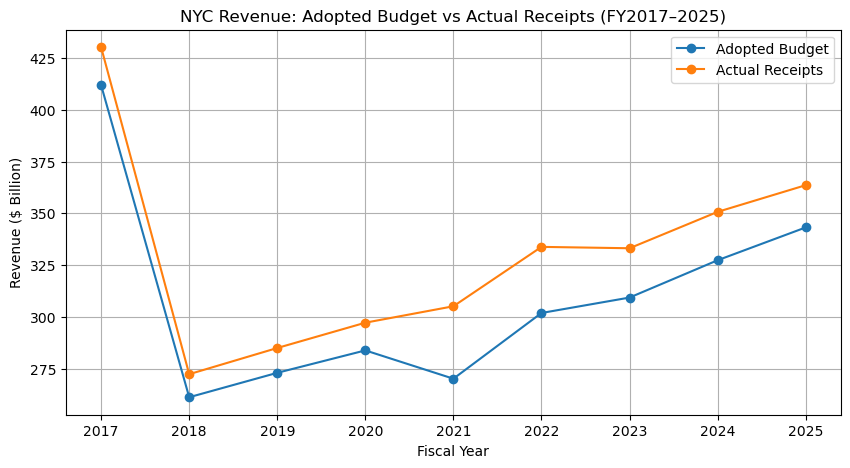

In [43]:
plt.figure(figsize=(10,5))
plt.plot(summary_year["fiscal_year"], summary_year["adopted_budget"]/1e9, marker='o', label="Adopted Budget")
plt.plot(summary_year["fiscal_year"], summary_year["actual"]/1e9, marker='o', label="Actual Receipts")
plt.title("NYC Revenue: Adopted Budget vs Actual Receipts (FY2017–2025)")
plt.xlabel("Fiscal Year")
plt.ylabel("Revenue ($ Billion)")
plt.grid(True)
plt.legend()
plt.show()

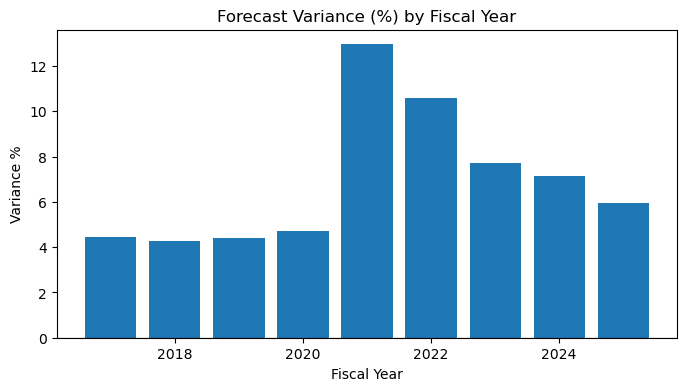

In [44]:
plt.figure(figsize=(8,4))
plt.bar(summary_year["fiscal_year"], summary_year["variance_%"]*100)
plt.title("Forecast Variance (%) by Fiscal Year")
plt.xlabel("Fiscal Year")
plt.ylabel("Variance %")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()

### Top Revenue Classes & Variance

In [45]:
REVENUE_COL = "revenue_class_name"

summary_class = (
    df.groupby(REVENUE_COL, as_index=False)
      .agg(
          actual=("year_1_revenue_amount","sum"),
          budget=("adopted_budget_amount","sum")
      )
)

summary_class["variance_$"] = summary_class["actual"] - summary_class["budget"]
summary_class["variance_%"] = summary_class["variance_$"] / summary_class["budget"]

# Top 10 by total revenue
top_classes = summary_class.sort_values("actual", ascending=False).head(10)
top_classes

,revenue_class_name,actual,budget,variance_$,variance_%
30,GENERAL PROPERTY TAXES,"850,874,820,000","845,257,972,000","5,616,848,000",0
36,INCOME TAXES,"631,684,000,000","593,119,000,000","38,565,000,000",0
17,EDUCATION,"423,975,776,101","418,727,496,532","5,248,279,569",0
31,GENERAL SALES TAX,"236,102,000,000","234,235,500,000","1,866,500,000",0
35,Health and Human Services,"128,082,322,397","111,542,774,287","16,539,548,110",0
58,OTHER TAXES,"94,714,700,000","92,443,090,000","2,271,610,000",0
65,SOCIAL SERVICES,"67,403,588,096","57,052,974,395","10,350,613,701",0
39,INTRA-CITY CHARGES,"63,303,673,639","54,158,971,569","9,144,702,070",0
74,WATER AND SEWER CHARGES,"49,171,200,000","48,202,088,200","969,111,800",0
34,HOUSING AND URBAN DEVELOPMENT,"47,517,795,417","34,752,605,009","12,765,190,408",0


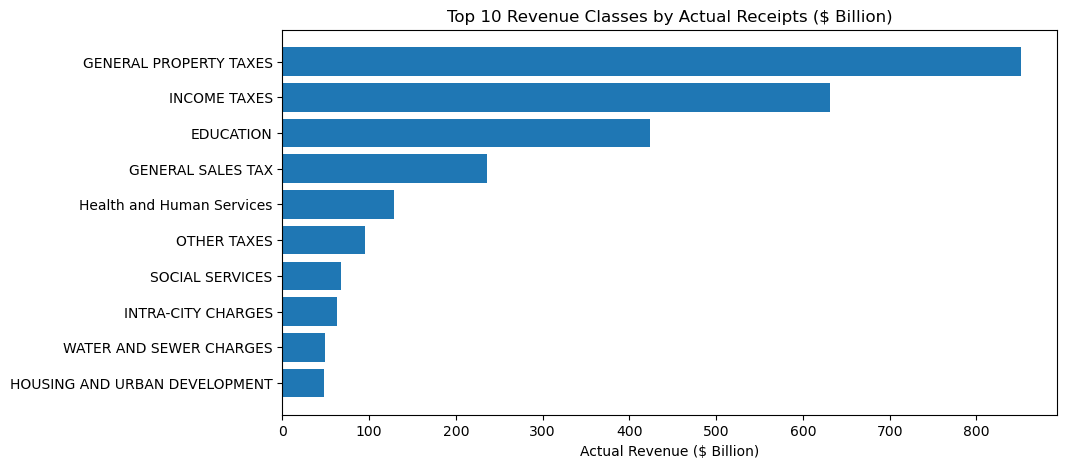

In [46]:
plt.figure(figsize=(10,5))
plt.barh(top_classes[REVENUE_COL], top_classes["actual"]/1e9)
plt.gca().invert_yaxis()
plt.title("Top 10 Revenue Classes by Actual Receipts ($ Billion)")
plt.xlabel("Actual Revenue ($ Billion)")
plt.show()

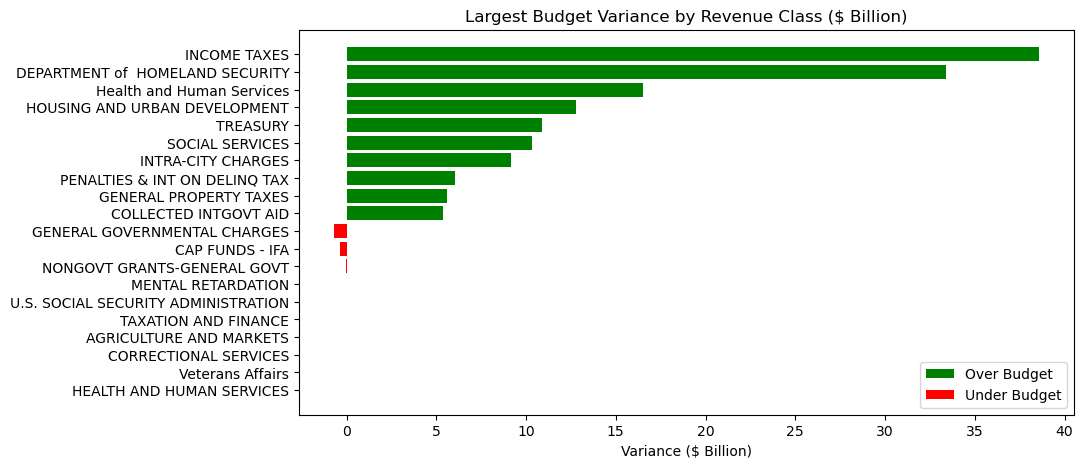

In [47]:
plt.figure(figsize=(10,5))
top_var = summary_class.sort_values("variance_$", ascending=False).head(10)
bottom_var = summary_class.sort_values("variance_$", ascending=True).head(10)

plt.barh(top_var[REVENUE_COL], top_var["variance_$"]/1e9, color="green", label="Over Budget")
plt.barh(bottom_var[REVENUE_COL], bottom_var["variance_$"]/1e9, color="red", label="Under Budget")
plt.gca().invert_yaxis()
plt.title("Largest Budget Variance by Revenue Class ($ Billion)")
plt.xlabel("Variance ($ Billion)")
plt.legend()
plt.show()